# Recurrent Neural Networks Models
In this notebook, we show an example of how RNNs can be used with darts.
If you are new to darts, we recommend you first follow the `darts-intro.ipynb` notebook.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd drive/MyDrive/Colab Notebooks/따릉이

/content/drive/MyDrive/Colab Notebooks/따릉이


In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
!pip install darts

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import shutil
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm

from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, ExponentialSmoothing, BlockRNNModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, SunspotsDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

## Recurrent Models

Darts includes two recurrent forecasting model classes: `RNNModel` and `BlockRNNModel`. 

`RNNModel` is fully recurrent in the sense that, at prediction time, an output is computed using these inputs:

- the previous target value, which will be set to the last known target value for the first prediction,
  and for all other predictions it will be set to the previous prediction
- the previous hidden state
- the current covariates (if the model was trained with covariates)

A prediction with forecasting horizon `n` thus is created in `n` iterations of `RNNModel` predictions and requires `n` future covariates to be known. This model is suited for forecasting problems where the target series is highly dependent on covariates that are known in advance.

`BlockRNNModel` has a recurrent encoder stage, which encodes its input, and a fully-connected neural network decoder stage, which produces a prediction of length `output_chunk_length` based on the last hidden state of the encoder stage. Consequently, this model produces 'blocks' of forecasts and is restricted to looking at covariates with the same time index as the input target series.

## Air Passenger Example
This is a data set that is highly dependent on covariates. Knowing the month tells us a lot about the seasonal component, whereas the year determines the effect of the trend component. Both of these covariates are known in the future, and thus the `RNNModel` class is the preferred choice for this problem.

In [105]:
#데이터 불러와서 하나로 합치기
import os

dong_df=pd.read_csv('data/train_dongdaemoon.csv')
gwang_df=pd.read_csv('data/train_gwangjin.csv')
jung_df=pd.read_csv('data/train_jungnang.csv')
seong_df=pd.read_csv('data/train_seongdong.csv')

In [106]:
def columns_reset(df, name):
  df.columns = ['일시', name, '승차총승객수', '하차총승객수', '평균기온', '최저기온', '최고기온',
       '강수 계속시간', '일강수량', '최대 풍속', '평균 풍속', '평균 상대습도',
       '합계 3시간 신적설', '안개 계속시간', '따릉이대여소', '버스하차총승객수_sum',
       '버스하차총승객수_mean', '버스하차총승객수_size']

In [107]:
columns_reset(gwang_df, '광진구')
columns_reset(dong_df, '동대문구')
columns_reset(jung_df, '중랑구')
columns_reset(seong_df, '성동구')

In [108]:
gwang_df['요일'] = pd.to_datetime(gwang_df.일시.astype(str)).dt.day_name()
dong_df['요일'] = pd.to_datetime(dong_df.일시.astype(str)).dt.day_name()
jung_df['요일'] = pd.to_datetime(jung_df.일시.astype(str)).dt.day_name()
seong_df['요일'] = pd.to_datetime(seong_df.일시.astype(str)).dt.day_name()

In [109]:
gwang_day_rank = pd.DataFrame(gwang_df.groupby('요일')['광진구'].mean()).reset_index()
dong_day_rank = pd.DataFrame(dong_df.groupby('요일')['동대문구'].mean()).reset_index()
jung_day_rank = pd.DataFrame(jung_df.groupby('요일')['중랑구'].mean()).reset_index()
seong_day_rank = pd.DataFrame(seong_df.groupby('요일')['성동구'].mean()).reset_index()

In [110]:
gwang_day_rank.columns = ['요일','요일_rank']
dong_day_rank.columns = ['요일','요일_rank']
jung_day_rank.columns = ['요일','요일_rank']
seong_day_rank.columns = ['요일','요일_rank']

In [111]:
gwang_df = pd.merge(gwang_df, gwang_day_rank, how='left', on='요일').drop(['합계 3시간 신적설','안개 계속시간','요일'],axis=1)
dong_df = pd.merge(dong_df, dong_day_rank, how='left', on='요일').drop(['합계 3시간 신적설','안개 계속시간','요일'],axis=1)
jung_df = pd.merge(jung_df, jung_day_rank, how='left', on='요일').drop(['합계 3시간 신적설','안개 계속시간','요일'],axis=1)
seong_df = pd.merge(seong_df, seong_day_rank, how='left', on='요일').drop(['합계 3시간 신적설','안개 계속시간','요일'],axis=1)

In [112]:
# gwang_df = gwang_df.drop(['승차총승객수','평균기온','최저기온','평균기온','최대 풍속','평균 상대습도','버스하차총승객수_sum','버스하차총승객수_mean'], axis=1)
# dong_df = dong_df.drop(['승차총승객수','평균기온','최저기온','평균기온','최대 풍속','평균 상대습도','버스하차총승객수_sum','버스하차총승객수_mean'], axis=1)
# jung_df = jung_df.drop(['승차총승객수','평균기온','최저기온','평균기온','최대 풍속','평균 상대습도','버스하차총승객수_sum','버스하차총승객수_mean'], axis=1)
# seong_df = seong_df.drop(['승차총승객수','평균기온','최저기온','평균기온','최대 풍속','평균 상대습도','버스하차총승객수_sum','버스하차총승객수_mean'], axis=1)

In [136]:
from darts import TimeSeries
from datetime import datetime

# Read a pandas DataFrame
#df = pd.read_csv('/content/drive/MyDrive/따릉이/data/train.csv')
df=seong_df

df['일시'] = df.일시.apply(lambda x: datetime.strptime(str(x),'%Y%m%d'))
#df.set_index('일시',inplace=True)
# Create a TimeSeries, specifying the time and value columns

# submit_v1206 columns - "일시", ['성동구', '하차총승객수', '최고기온', '강수 계속시간', '일강수량', '평균 풍속', '따릉이대여소', '버스하차총승객수_size', '요일_rank'] -> 2.79
# 4개 다 따로 돌림
series = TimeSeries.from_dataframe(df, "일시", ['성동구', '평균기온', '평균 풍속', '버스하차총승객수_size', '요일_rank'])

# Set aside the last 36 months as a validation series
train, val = series[:1096], series[1096:]
## Read data:
#series = AirPassengersDataset().load()

## Create training and validation sets:
#train, val = series.split_after(pd.Timestamp("19590101"))

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

# create month and year covariate series
year_series = datetime_attribute_timeseries(
    pd.date_range(start=series.start_time(), freq=series.freq_str, periods=1795),
    attribute="year",
    one_hot=False,
)
year_series = Scaler().fit_transform(year_series)
month_series = datetime_attribute_timeseries(
    year_series, attribute="month", one_hot=True
)
covariates = year_series.stack(month_series)
cov_train, cov_val = covariates.split_after(pd.Timestamp("2020-12-31"))

Let's train an LSTM neural net. For using vanilla RNN or GRU instead, replace `'LSTM'` by `'RNN'` or `'GRU'`, respectively.

In [137]:
my_model = RNNModel(
    model="LSTM", #이부분 수정시 GRU, RNN 사용 가능 
    hidden_dim=20,
    dropout=0,
    batch_size=16,
    n_epochs=200,
    optimizer_kwargs={"lr": 1e-3},
    model_name="Air_RNN",
    log_tensorboard=True,
    random_state=42,
    training_length=20,
    input_chunk_length=168,#time step 1시간단위 인듯 이부분 수정
    force_reset=True,
    save_checkpoints=True
)

In what follows, we can just provide the whole `covariates` series as `future_covariates` argument to the model; the model will slice these covariates and use only what it needs in order to train on forecasting the target `train_transformed`:

In [ ]:
my_model.fit(
    train_transformed,
    future_covariates=covariates,
    val_series=val_transformed,
    val_future_covariates=covariates,
    verbose=True,
)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

### Look at predictions on the validation set
Use the "current" model - i.e., the model at the end of the training procedure:

In [ ]:
# def eval_model(model):
#     pred_series = model.predict(n=699, future_covariates=covariates)
#     plt.figure(figsize=(8, 5))
#     series_transformed.plot(label="actual")
#     pred_series.plot(label="forecast")
#     plt.title("MAPE: {:.2f}%".format(mape(pred_series, val_transformed)))
#     plt.legend()
    
# eval_model(my_model)

In [119]:
best_model_g = RNNModel.load_from_checkpoint(model_name="Air_RNN", best=True)
# eval_model(best_model_g)
pred_series = best_model_g.predict(n=699, future_covariates=covariates)
mape(pred_series, val_transformed)

Predicting: 0it [00:00, ?it/s]

97.99531003364227

In [127]:
best_model_d = RNNModel.load_from_checkpoint(model_name="Air_RNN", best=True)
# eval_model(best_model_d)
pred_series = best_model_d.predict(n=699, future_covariates=covariates)
mape(pred_series, val_transformed)

Predicting: 0it [00:00, ?it/s]

131.80688410953778

In [133]:
best_model_j = RNNModel.load_from_checkpoint(model_name="Air_RNN", best=True)
# eval_model(best_model_j)
pred_series = best_model_j.predict(n=699, future_covariates=covariates)
mape(pred_series, val_transformed)

Predicting: 0it [00:00, ?it/s]

54.27084877234015

In [ ]:
best_model_s = RNNModel.load_from_checkpoint(model_name="Air_RNN", best=True)
# eval_model(best_model_s)
pred_series = best_model_s.predict(n=699, future_covariates=covariates)
mape(pred_series, val_transformed)

In [120]:
ff_g=best_model_g.predict(n=699, future_covariates=covariates)# predict
ff_g=transformer.inverse_transform(ff_g) #역 정규화
last_pred_g=ff_g[365:699]#2022년1월1일 2022년 11월30일
last_pred_g=last_pred_g.pd_dataframe() # 데이터프레임 변환
last_pred_g=last_pred_g.applymap(lambda x: 0 if x < 0 else x).reset_index() # -값 0으로 치환

Predicting: 0it [00:00, ?it/s]

In [121]:
last_pred_g.max(),last_pred_g.min(),last_pred_g.mean()

(component
 일시               2022-11-30 00:00:00
 광진구                        14.057243
 평균기온                       25.617904
 평균 풍속                       3.444234
 버스하차총승객수_size               787.2776
 요일_rank                     6.457314
 dtype: object, component
 일시               2022-01-01 00:00:00
 광진구                         4.205463
 평균기온                        0.485587
 평균 풍속                        2.21518
 버스하차총승객수_size             740.194835
 요일_rank                     5.801441
 dtype: object, component
 광진구                9.569196
 평균기온              14.324433
 평균 풍속              2.882402
 버스하차총승객수_size    761.966154
 요일_rank            6.200745
 dtype: float64)

In [128]:
ff_d=best_model_d.predict(n=699, future_covariates=covariates)# predict
ff_d=transformer.inverse_transform(ff_d) #역 정규화
last_pred_d=ff_d[365:699]#2022년1월1일 2022년 11월30일
last_pred_d=last_pred_d.pd_dataframe() # 데이터프레임 변환
last_pred_d=last_pred_d.applymap(lambda x: 0 if x < 0 else x).reset_index() # -값 0으로 치환

Predicting: 0it [00:00, ?it/s]

In [129]:
last_pred_d.max(),last_pred_d.min(),last_pred_d.mean()

(component
 일시               2022-11-30 00:00:00
 동대문구                       10.003733
 평균기온                       27.708709
 평균 풍속                       3.480018
 버스하차총승객수_size            1377.791565
 요일_rank                     4.553887
 dtype: object, component
 일시               2022-01-01 00:00:00
 동대문구                        3.288028
 평균기온                         4.19237
 평균 풍속                        2.37836
 버스하차총승객수_size             1321.49764
 요일_rank                     3.514279
 dtype: object, component
 동대문구                7.836114
 평균기온               16.376679
 평균 풍속               2.966298
 버스하차총승객수_size    1352.719588
 요일_rank             4.227839
 dtype: float64)

In [134]:
ff_j=best_model_j.predict(n=699, future_covariates=covariates)# predict
ff_j=transformer.inverse_transform(ff_j) #역 정규화
last_pred_j=ff_j[365:699]#2022년1월1일 2022년 11월30일
last_pred_j=last_pred_j.pd_dataframe() # 데이터프레임 변환
last_pred_j=last_pred_j.applymap(lambda x: 0 if x < 0 else x).reset_index() # -값 0으로 치환

Predicting: 0it [00:00, ?it/s]

In [135]:
last_pred_j.max(),last_pred_j.min(),last_pred_j.mean()

(component
 일시               2022-11-30 00:00:00
 중랑구                         8.045828
 평균기온                       28.793397
 평균 풍속                       3.686684
 버스하차총승객수_size            1502.018227
 요일_rank                     3.303433
 dtype: object, component
 일시               2022-01-01 00:00:00
 중랑구                           2.2757
 평균기온                         2.84751
 평균 풍속                       2.485196
 버스하차총승객수_size            1395.902262
 요일_rank                     2.858414
 dtype: object, component
 중랑구                 6.055264
 평균기온               16.129781
 평균 풍속               3.116064
 버스하차총승객수_size    1456.525704
 요일_rank             3.133810
 dtype: float64)

In [ ]:
ff_s=best_model_s.predict(n=699, future_covariates=covariates)# predict
ff_s=transformer.inverse_transform(ff_s) #역 정규화
last_pred_s=ff_s[365:699]#2022년1월1일 2022년 11월30일
last_pred_s=last_pred_s.pd_dataframe() # 데이터프레임 변환
last_pred_s=last_pred_s.applymap(lambda x: 0 if x < 0 else x).reset_index() # -값 0으로 치환

In [ ]:
last_pred_s.max(),last_pred_s.min()

In [73]:
submit = pd.read_csv('sample_submission.csv')
submit.head()
submit['광진구']=last_pred_g.광진구
submit['동대문구']=last_pred_d.동대문구
submit['성동구']=last_pred_s.성동구
submit['중랑구']=last_pred_j.중랑구
submit=submit.set_index('일시')
# submit.to_csv('/content/drive/MyDrive/따릉이/data/submit/submit_mseloss_따로_풍속_기온.csv')

In [75]:
submit.max(), submit.min(), submit.mean()

(광진구     16.676874
 동대문구    10.187996
 성동구     11.695137
 중랑구      8.098946
 dtype: float64, 광진구     7.717690
 동대문구    4.589710
 성동구     4.605632
 중랑구     3.563469
 dtype: float64, 광진구     12.223781
 동대문구     7.371334
 성동구      9.299052
 중랑구      6.145503
 dtype: float64)

In [77]:
submit.to_csv('submit_v1206.csv')

Use the best model obtained over training, according to validation loss:

Predicting: 0it [00:00, ?it/s]

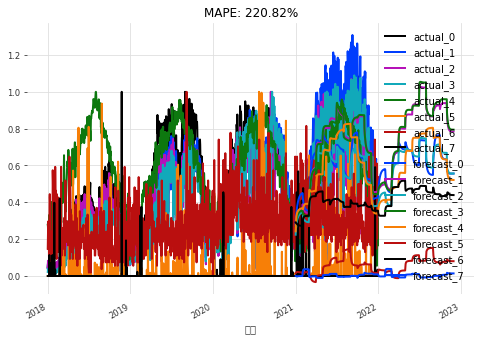

### Backtesting
Let's backtest our `RNN` model, to see how it performs at a forecast horizon of 6 months:

In [ ]:
backtest_series = my_model.historical_forecasts(
    series_transformed,
    future_covariates=covariates,
    start=pd.Timestamp("20210101"),
    forecast_horizon=6,
    retrain=False,
    verbose=True,
)

  0%|          | 0/360 [00:00<?, ?it/s]

Predicting: 68it [00:00, ?it/s]

  0%|          | 1/360 [00:00<01:07,  5.28it/s]

Predicting: 68it [00:00, ?it/s]

  1%|          | 2/360 [00:00<00:55,  6.49it/s]

Predicting: 68it [00:00, ?it/s]

  1%|          | 3/360 [00:00<00:57,  6.22it/s]

Predicting: 68it [00:00, ?it/s]

  1%|          | 4/360 [00:00<00:50,  7.02it/s]

Predicting: 68it [00:00, ?it/s]

  1%|▏         | 5/360 [00:00<01:10,  5.01it/s]

Predicting: 68it [00:00, ?it/s]

  2%|▏         | 6/360 [00:01<01:26,  4.08it/s]

Predicting: 68it [00:00, ?it/s]

  2%|▏         | 7/360 [00:01<01:33,  3.77it/s]

Predicting: 68it [00:00, ?it/s]

  2%|▏         | 8/360 [00:01<01:31,  3.83it/s]

Predicting: 68it [00:00, ?it/s]

  2%|▎         | 9/360 [00:01<01:17,  4.51it/s]

Predicting: 68it [00:00, ?it/s]

  3%|▎         | 10/360 [00:02<01:04,  5.39it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

  3%|▎         | 12/360 [00:02<00:51,  6.72it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

  4%|▍         | 14/360 [00:02<00:43,  7.87it/s]

Predicting: 68it [00:00, ?it/s]

  4%|▍         | 15/360 [00:02<00:42,  8.14it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

  5%|▍         | 17/360 [00:02<00:38,  8.87it/s]

Predicting: 68it [00:00, ?it/s]

  5%|▌         | 18/360 [00:02<00:37,  9.07it/s]

Predicting: 68it [00:00, ?it/s]

  5%|▌         | 19/360 [00:02<00:37,  9.17it/s]

Predicting: 68it [00:00, ?it/s]

  6%|▌         | 20/360 [00:03<00:37,  9.09it/s]

Predicting: 68it [00:00, ?it/s]

  6%|▌         | 21/360 [00:03<00:37,  8.93it/s]

Predicting: 68it [00:00, ?it/s]

  6%|▌         | 22/360 [00:03<00:37,  9.07it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

  7%|▋         | 24/360 [00:03<00:35,  9.52it/s]

Predicting: 68it [00:00, ?it/s]

  7%|▋         | 25/360 [00:03<00:34,  9.59it/s]

Predicting: 68it [00:00, ?it/s]

  7%|▋         | 26/360 [00:03<00:34,  9.64it/s]

Predicting: 68it [00:00, ?it/s]

  8%|▊         | 27/360 [00:03<00:36,  9.16it/s]

Predicting: 68it [00:00, ?it/s]

  8%|▊         | 28/360 [00:03<00:37,  8.79it/s]

Predicting: 68it [00:00, ?it/s]

  8%|▊         | 29/360 [00:04<00:40,  8.26it/s]

Predicting: 68it [00:00, ?it/s]

  8%|▊         | 30/360 [00:04<00:39,  8.34it/s]

Predicting: 68it [00:00, ?it/s]

  9%|▊         | 31/360 [00:04<00:39,  8.41it/s]

Predicting: 68it [00:00, ?it/s]

  9%|▉         | 32/360 [00:04<00:37,  8.75it/s]

Predicting: 68it [00:00, ?it/s]

  9%|▉         | 33/360 [00:04<00:37,  8.77it/s]

Predicting: 68it [00:00, ?it/s]

  9%|▉         | 34/360 [00:04<00:36,  8.96it/s]

Predicting: 68it [00:00, ?it/s]

 10%|▉         | 35/360 [00:04<00:35,  9.04it/s]

Predicting: 68it [00:00, ?it/s]

 10%|█         | 36/360 [00:04<00:37,  8.73it/s]

Predicting: 68it [00:00, ?it/s]

 10%|█         | 37/360 [00:04<00:38,  8.48it/s]

Predicting: 68it [00:00, ?it/s]

 11%|█         | 38/360 [00:05<00:38,  8.26it/s]

Predicting: 68it [00:00, ?it/s]

 11%|█         | 39/360 [00:05<00:40,  7.86it/s]

Predicting: 68it [00:00, ?it/s]

 11%|█         | 40/360 [00:05<00:41,  7.77it/s]

Predicting: 68it [00:00, ?it/s]

 11%|█▏        | 41/360 [00:05<00:41,  7.73it/s]

Predicting: 68it [00:00, ?it/s]

 12%|█▏        | 42/360 [00:05<00:40,  7.88it/s]

Predicting: 68it [00:00, ?it/s]

 12%|█▏        | 43/360 [00:05<00:38,  8.15it/s]

Predicting: 68it [00:00, ?it/s]

 12%|█▏        | 44/360 [00:05<00:39,  8.02it/s]

Predicting: 68it [00:00, ?it/s]

 12%|█▎        | 45/360 [00:06<00:41,  7.59it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 13%|█▎        | 47/360 [00:06<00:36,  8.53it/s]

Predicting: 68it [00:00, ?it/s]

 13%|█▎        | 48/360 [00:06<00:36,  8.54it/s]

Predicting: 68it [00:00, ?it/s]

 14%|█▎        | 49/360 [00:06<00:36,  8.45it/s]

Predicting: 68it [00:00, ?it/s]

 14%|█▍        | 50/360 [00:06<00:36,  8.59it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 14%|█▍        | 52/360 [00:06<00:33,  9.16it/s]

Predicting: 68it [00:00, ?it/s]

 15%|█▍        | 53/360 [00:06<00:34,  8.95it/s]

Predicting: 68it [00:00, ?it/s]

 15%|█▌        | 54/360 [00:07<00:38,  8.04it/s]

Predicting: 68it [00:00, ?it/s]

 15%|█▌        | 55/360 [00:07<00:36,  8.27it/s]

Predicting: 68it [00:00, ?it/s]

 16%|█▌        | 56/360 [00:07<00:35,  8.54it/s]

Predicting: 68it [00:00, ?it/s]

 16%|█▌        | 57/360 [00:07<00:34,  8.72it/s]

Predicting: 68it [00:00, ?it/s]

 16%|█▌        | 58/360 [00:07<00:34,  8.79it/s]

Predicting: 68it [00:00, ?it/s]

 16%|█▋        | 59/360 [00:07<00:34,  8.66it/s]

Predicting: 68it [00:00, ?it/s]

 17%|█▋        | 60/360 [00:07<00:34,  8.72it/s]

Predicting: 68it [00:00, ?it/s]

 17%|█▋        | 61/360 [00:07<00:35,  8.46it/s]

Predicting: 68it [00:00, ?it/s]

 17%|█▋        | 62/360 [00:07<00:34,  8.64it/s]

Predicting: 68it [00:00, ?it/s]

 18%|█▊        | 63/360 [00:08<00:33,  8.81it/s]

Predicting: 68it [00:00, ?it/s]

 18%|█▊        | 64/360 [00:08<00:32,  9.00it/s]

Predicting: 68it [00:00, ?it/s]

 18%|█▊        | 65/360 [00:08<00:35,  8.29it/s]

Predicting: 68it [00:00, ?it/s]

 18%|█▊        | 66/360 [00:08<00:38,  7.69it/s]

Predicting: 68it [00:00, ?it/s]

 19%|█▊        | 67/360 [00:08<00:37,  7.84it/s]

Predicting: 68it [00:00, ?it/s]

 19%|█▉        | 68/360 [00:08<00:40,  7.15it/s]

Predicting: 68it [00:00, ?it/s]

 19%|█▉        | 69/360 [00:08<00:37,  7.72it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 20%|█▉        | 71/360 [00:09<00:36,  7.97it/s]

Predicting: 68it [00:00, ?it/s]

 20%|██        | 72/360 [00:09<00:34,  8.36it/s]

Predicting: 68it [00:00, ?it/s]

 20%|██        | 73/360 [00:09<00:37,  7.76it/s]

Predicting: 68it [00:00, ?it/s]

 21%|██        | 74/360 [00:09<00:36,  7.75it/s]

Predicting: 68it [00:00, ?it/s]

 21%|██        | 75/360 [00:09<00:38,  7.48it/s]

Predicting: 68it [00:00, ?it/s]

 21%|██        | 76/360 [00:09<00:39,  7.11it/s]

Predicting: 68it [00:00, ?it/s]

 21%|██▏       | 77/360 [00:09<00:37,  7.54it/s]

Predicting: 68it [00:00, ?it/s]

 22%|██▏       | 78/360 [00:10<00:36,  7.77it/s]

Predicting: 68it [00:00, ?it/s]

 22%|██▏       | 79/360 [00:10<00:35,  7.96it/s]

Predicting: 68it [00:00, ?it/s]

 22%|██▏       | 80/360 [00:10<00:35,  7.96it/s]

Predicting: 68it [00:00, ?it/s]

 22%|██▎       | 81/360 [00:10<00:33,  8.32it/s]

Predicting: 68it [00:00, ?it/s]

 23%|██▎       | 82/360 [00:10<00:33,  8.38it/s]

Predicting: 68it [00:00, ?it/s]

 23%|██▎       | 83/360 [00:10<00:34,  8.03it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 24%|██▎       | 85/360 [00:10<00:30,  8.90it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 24%|██▍       | 87/360 [00:11<00:29,  9.26it/s]

Predicting: 68it [00:00, ?it/s]

 24%|██▍       | 88/360 [00:11<00:30,  8.92it/s]

Predicting: 68it [00:00, ?it/s]

 25%|██▍       | 89/360 [00:11<00:33,  8.15it/s]

Predicting: 68it [00:00, ?it/s]

 25%|██▌       | 90/360 [00:11<00:34,  7.86it/s]

Predicting: 68it [00:00, ?it/s]

 25%|██▌       | 91/360 [00:11<00:34,  7.81it/s]

Predicting: 68it [00:00, ?it/s]

 26%|██▌       | 92/360 [00:11<00:33,  8.05it/s]

Predicting: 68it [00:00, ?it/s]

 26%|██▌       | 93/360 [00:11<00:31,  8.40it/s]

Predicting: 68it [00:00, ?it/s]

 26%|██▌       | 94/360 [00:11<00:30,  8.65it/s]

Predicting: 68it [00:00, ?it/s]

 26%|██▋       | 95/360 [00:12<00:29,  8.93it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 27%|██▋       | 97/360 [00:12<00:27,  9.56it/s]

Predicting: 68it [00:00, ?it/s]

 27%|██▋       | 98/360 [00:12<00:27,  9.45it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 28%|██▊       | 100/360 [00:12<00:27,  9.54it/s]

Predicting: 68it [00:00, ?it/s]

 28%|██▊       | 101/360 [00:12<00:30,  8.52it/s]

Predicting: 68it [00:00, ?it/s]

 28%|██▊       | 102/360 [00:12<00:31,  8.25it/s]

Predicting: 68it [00:00, ?it/s]

 29%|██▊       | 103/360 [00:12<00:31,  8.23it/s]

Predicting: 68it [00:00, ?it/s]

 29%|██▉       | 104/360 [00:13<00:32,  7.92it/s]

Predicting: 68it [00:00, ?it/s]

 29%|██▉       | 105/360 [00:13<00:31,  8.21it/s]

Predicting: 68it [00:00, ?it/s]

 29%|██▉       | 106/360 [00:13<00:32,  7.91it/s]

Predicting: 68it [00:00, ?it/s]

 30%|██▉       | 107/360 [00:13<00:32,  7.78it/s]

Predicting: 68it [00:00, ?it/s]

 30%|███       | 108/360 [00:13<00:34,  7.33it/s]

Predicting: 68it [00:00, ?it/s]

 30%|███       | 109/360 [00:13<00:33,  7.54it/s]

Predicting: 68it [00:00, ?it/s]

 31%|███       | 110/360 [00:13<00:33,  7.49it/s]

Predicting: 68it [00:00, ?it/s]

 31%|███       | 111/360 [00:13<00:31,  7.99it/s]

Predicting: 68it [00:00, ?it/s]

 31%|███       | 112/360 [00:14<00:32,  7.61it/s]

Predicting: 68it [00:00, ?it/s]

 31%|███▏      | 113/360 [00:14<00:34,  7.11it/s]

Predicting: 68it [00:00, ?it/s]

 32%|███▏      | 114/360 [00:14<00:33,  7.32it/s]

Predicting: 68it [00:00, ?it/s]

 32%|███▏      | 115/360 [00:14<00:35,  6.86it/s]

Predicting: 68it [00:00, ?it/s]

 32%|███▏      | 116/360 [00:14<00:34,  7.06it/s]

Predicting: 68it [00:00, ?it/s]

 32%|███▎      | 117/360 [00:14<00:32,  7.40it/s]

Predicting: 68it [00:00, ?it/s]

 33%|███▎      | 118/360 [00:14<00:30,  7.82it/s]

Predicting: 68it [00:00, ?it/s]

 33%|███▎      | 119/360 [00:15<00:29,  8.16it/s]

Predicting: 68it [00:00, ?it/s]

 33%|███▎      | 120/360 [00:15<00:28,  8.39it/s]

Predicting: 68it [00:00, ?it/s]

 34%|███▎      | 121/360 [00:15<00:27,  8.59it/s]

Predicting: 68it [00:00, ?it/s]

 34%|███▍      | 122/360 [00:15<00:27,  8.53it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 34%|███▍      | 124/360 [00:15<00:27,  8.73it/s]

Predicting: 68it [00:00, ?it/s]

 35%|███▍      | 125/360 [00:15<00:26,  8.73it/s]

Predicting: 68it [00:00, ?it/s]

 35%|███▌      | 126/360 [00:15<00:27,  8.66it/s]

Predicting: 68it [00:00, ?it/s]

 35%|███▌      | 127/360 [00:16<00:29,  7.88it/s]

Predicting: 68it [00:00, ?it/s]

 36%|███▌      | 128/360 [00:16<00:30,  7.72it/s]

Predicting: 68it [00:00, ?it/s]

 36%|███▌      | 129/360 [00:16<00:28,  8.13it/s]

Predicting: 68it [00:00, ?it/s]

 36%|███▌      | 130/360 [00:16<00:29,  7.77it/s]

Predicting: 68it [00:00, ?it/s]

 36%|███▋      | 131/360 [00:16<00:28,  7.91it/s]

Predicting: 68it [00:00, ?it/s]

 37%|███▋      | 132/360 [00:16<00:31,  7.20it/s]

Predicting: 68it [00:00, ?it/s]

 37%|███▋      | 133/360 [00:16<00:30,  7.33it/s]

Predicting: 68it [00:00, ?it/s]

 37%|███▋      | 134/360 [00:16<00:30,  7.30it/s]

Predicting: 68it [00:00, ?it/s]

 38%|███▊      | 135/360 [00:17<00:31,  7.07it/s]

Predicting: 68it [00:00, ?it/s]

 38%|███▊      | 136/360 [00:17<00:31,  7.20it/s]

Predicting: 68it [00:00, ?it/s]

 38%|███▊      | 137/360 [00:17<00:32,  6.97it/s]

Predicting: 68it [00:00, ?it/s]

 38%|███▊      | 138/360 [00:17<00:29,  7.42it/s]

Predicting: 68it [00:00, ?it/s]

 39%|███▊      | 139/360 [00:17<00:27,  8.02it/s]

Predicting: 68it [00:00, ?it/s]

 39%|███▉      | 140/360 [00:17<00:26,  8.42it/s]

Predicting: 68it [00:00, ?it/s]

 39%|███▉      | 141/360 [00:17<00:25,  8.48it/s]

Predicting: 68it [00:00, ?it/s]

 39%|███▉      | 142/360 [00:18<00:29,  7.46it/s]

Predicting: 68it [00:00, ?it/s]

 40%|███▉      | 143/360 [00:18<00:27,  7.84it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 40%|████      | 145/360 [00:18<00:24,  8.81it/s]

Predicting: 68it [00:00, ?it/s]

 41%|████      | 146/360 [00:18<00:23,  8.96it/s]

Predicting: 68it [00:00, ?it/s]

 41%|████      | 147/360 [00:18<00:23,  8.98it/s]

Predicting: 68it [00:00, ?it/s]

 41%|████      | 148/360 [00:18<00:24,  8.62it/s]

Predicting: 68it [00:00, ?it/s]

 41%|████▏     | 149/360 [00:18<00:25,  8.39it/s]

Predicting: 68it [00:00, ?it/s]

 42%|████▏     | 150/360 [00:18<00:24,  8.67it/s]

Predicting: 68it [00:00, ?it/s]

 42%|████▏     | 151/360 [00:19<00:24,  8.52it/s]

Predicting: 68it [00:00, ?it/s]

 42%|████▏     | 152/360 [00:19<00:23,  8.87it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 43%|████▎     | 154/360 [00:19<00:21,  9.42it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 43%|████▎     | 156/360 [00:19<00:20,  9.81it/s]

Predicting: 68it [00:00, ?it/s]

 44%|████▎     | 157/360 [00:19<00:23,  8.67it/s]

Predicting: 68it [00:00, ?it/s]

 44%|████▍     | 158/360 [00:19<00:23,  8.76it/s]

Predicting: 68it [00:00, ?it/s]

 44%|████▍     | 159/360 [00:19<00:23,  8.60it/s]

Predicting: 68it [00:00, ?it/s]

 44%|████▍     | 160/360 [00:20<00:24,  8.32it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 45%|████▌     | 162/360 [00:20<00:22,  9.00it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 46%|████▌     | 164/360 [00:20<00:20,  9.50it/s]

Predicting: 68it [00:00, ?it/s]

 46%|████▌     | 165/360 [00:20<00:20,  9.32it/s]

Predicting: 68it [00:00, ?it/s]

 46%|████▌     | 166/360 [00:20<00:22,  8.47it/s]

Predicting: 68it [00:00, ?it/s]

 46%|████▋     | 167/360 [00:20<00:23,  8.28it/s]

Predicting: 68it [00:00, ?it/s]

 47%|████▋     | 168/360 [00:20<00:23,  8.31it/s]

Predicting: 68it [00:00, ?it/s]

 47%|████▋     | 169/360 [00:21<00:23,  8.20it/s]

Predicting: 68it [00:00, ?it/s]

 47%|████▋     | 170/360 [00:21<00:23,  7.98it/s]

Predicting: 68it [00:00, ?it/s]

 48%|████▊     | 171/360 [00:21<00:26,  7.25it/s]

Predicting: 68it [00:00, ?it/s]

 48%|████▊     | 172/360 [00:21<00:24,  7.77it/s]

Predicting: 68it [00:00, ?it/s]

 48%|████▊     | 173/360 [00:21<00:24,  7.49it/s]

Predicting: 68it [00:00, ?it/s]

 48%|████▊     | 174/360 [00:21<00:23,  7.83it/s]

Predicting: 68it [00:00, ?it/s]

 49%|████▊     | 175/360 [00:21<00:24,  7.60it/s]

Predicting: 68it [00:00, ?it/s]

 49%|████▉     | 176/360 [00:21<00:23,  7.78it/s]

Predicting: 68it [00:00, ?it/s]

 49%|████▉     | 177/360 [00:22<00:23,  7.78it/s]

Predicting: 68it [00:00, ?it/s]

 49%|████▉     | 178/360 [00:22<00:22,  8.21it/s]

Predicting: 68it [00:00, ?it/s]

 50%|████▉     | 179/360 [00:22<00:23,  7.66it/s]

Predicting: 68it [00:00, ?it/s]

 50%|█████     | 180/360 [00:22<00:23,  7.65it/s]

Predicting: 68it [00:00, ?it/s]

 50%|█████     | 181/360 [00:22<00:21,  8.17it/s]

Predicting: 68it [00:00, ?it/s]

 51%|█████     | 182/360 [00:22<00:21,  8.35it/s]

Predicting: 68it [00:00, ?it/s]

 51%|█████     | 183/360 [00:22<00:20,  8.43it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 51%|█████▏    | 185/360 [00:23<00:21,  8.10it/s]

Predicting: 68it [00:00, ?it/s]

 52%|█████▏    | 186/360 [00:23<00:21,  8.01it/s]

Predicting: 68it [00:00, ?it/s]

 52%|█████▏    | 187/360 [00:23<00:22,  7.67it/s]

Predicting: 68it [00:00, ?it/s]

 52%|█████▏    | 188/360 [00:23<00:22,  7.71it/s]

Predicting: 68it [00:00, ?it/s]

 52%|█████▎    | 189/360 [00:23<00:22,  7.64it/s]

Predicting: 68it [00:00, ?it/s]

 53%|█████▎    | 190/360 [00:23<00:20,  8.19it/s]

Predicting: 68it [00:00, ?it/s]

 53%|█████▎    | 191/360 [00:23<00:20,  8.41it/s]

Predicting: 68it [00:00, ?it/s]

 53%|█████▎    | 192/360 [00:23<00:20,  8.10it/s]

Predicting: 68it [00:00, ?it/s]

 54%|█████▎    | 193/360 [00:24<00:22,  7.51it/s]

Predicting: 68it [00:00, ?it/s]

 54%|█████▍    | 194/360 [00:24<00:22,  7.44it/s]

Predicting: 68it [00:00, ?it/s]

 54%|█████▍    | 195/360 [00:24<00:20,  7.87it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 55%|█████▍    | 197/360 [00:24<00:19,  8.30it/s]

Predicting: 68it [00:00, ?it/s]

 55%|█████▌    | 198/360 [00:24<00:19,  8.16it/s]

Predicting: 68it [00:00, ?it/s]

 55%|█████▌    | 199/360 [00:24<00:19,  8.05it/s]

Predicting: 68it [00:00, ?it/s]

 56%|█████▌    | 200/360 [00:24<00:18,  8.47it/s]

Predicting: 68it [00:00, ?it/s]

 56%|█████▌    | 201/360 [00:25<00:19,  8.23it/s]

Predicting: 68it [00:00, ?it/s]

 56%|█████▌    | 202/360 [00:25<00:18,  8.49it/s]

Predicting: 68it [00:00, ?it/s]

 56%|█████▋    | 203/360 [00:25<00:18,  8.42it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 57%|█████▋    | 205/360 [00:25<00:17,  8.83it/s]

Predicting: 68it [00:00, ?it/s]

 57%|█████▋    | 206/360 [00:25<00:18,  8.17it/s]

Predicting: 68it [00:00, ?it/s]

 57%|█████▊    | 207/360 [00:25<00:19,  8.03it/s]

Predicting: 68it [00:00, ?it/s]

 58%|█████▊    | 208/360 [00:26<00:20,  7.26it/s]

Predicting: 68it [00:00, ?it/s]

 58%|█████▊    | 209/360 [00:26<00:21,  7.14it/s]

Predicting: 68it [00:00, ?it/s]

 58%|█████▊    | 210/360 [00:26<00:21,  7.13it/s]

Predicting: 68it [00:00, ?it/s]

 59%|█████▊    | 211/360 [00:26<00:22,  6.73it/s]

Predicting: 68it [00:00, ?it/s]

 59%|█████▉    | 212/360 [00:26<00:25,  5.78it/s]

Predicting: 68it [00:00, ?it/s]

 59%|█████▉    | 213/360 [00:26<00:24,  6.04it/s]

Predicting: 68it [00:00, ?it/s]

 59%|█████▉    | 214/360 [00:26<00:22,  6.60it/s]

Predicting: 68it [00:00, ?it/s]

 60%|█████▉    | 215/360 [00:27<00:20,  6.98it/s]

Predicting: 68it [00:00, ?it/s]

 60%|██████    | 216/360 [00:27<00:18,  7.59it/s]

Predicting: 68it [00:00, ?it/s]

 60%|██████    | 217/360 [00:27<00:19,  7.42it/s]

Predicting: 68it [00:00, ?it/s]

 61%|██████    | 218/360 [00:27<00:18,  7.73it/s]

Predicting: 68it [00:00, ?it/s]

 61%|██████    | 219/360 [00:27<00:17,  8.12it/s]

Predicting: 68it [00:00, ?it/s]

 61%|██████    | 220/360 [00:27<00:16,  8.46it/s]

Predicting: 68it [00:00, ?it/s]

 61%|██████▏   | 221/360 [00:27<00:16,  8.64it/s]

Predicting: 68it [00:00, ?it/s]

 62%|██████▏   | 222/360 [00:27<00:15,  8.76it/s]

Predicting: 68it [00:00, ?it/s]

 62%|██████▏   | 223/360 [00:27<00:15,  8.71it/s]

Predicting: 68it [00:00, ?it/s]

 62%|██████▏   | 224/360 [00:28<00:17,  7.93it/s]

Predicting: 68it [00:00, ?it/s]

 62%|██████▎   | 225/360 [00:28<00:18,  7.39it/s]

Predicting: 68it [00:00, ?it/s]

 63%|██████▎   | 226/360 [00:28<00:17,  7.74it/s]

Predicting: 68it [00:00, ?it/s]

 63%|██████▎   | 227/360 [00:28<00:17,  7.43it/s]

Predicting: 68it [00:00, ?it/s]

 63%|██████▎   | 228/360 [00:28<00:18,  7.30it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 64%|██████▍   | 230/360 [00:28<00:15,  8.13it/s]

Predicting: 68it [00:00, ?it/s]

 64%|██████▍   | 231/360 [00:29<00:15,  8.19it/s]

Predicting: 68it [00:00, ?it/s]

 64%|██████▍   | 232/360 [00:29<00:15,  8.06it/s]

Predicting: 68it [00:00, ?it/s]

 65%|██████▍   | 233/360 [00:29<00:15,  8.45it/s]

Predicting: 68it [00:00, ?it/s]

 65%|██████▌   | 234/360 [00:29<00:15,  8.36it/s]

Predicting: 68it [00:00, ?it/s]

 65%|██████▌   | 235/360 [00:29<00:14,  8.36it/s]

Predicting: 68it [00:00, ?it/s]

 66%|██████▌   | 236/360 [00:29<00:15,  8.08it/s]

Predicting: 68it [00:00, ?it/s]

 66%|██████▌   | 237/360 [00:29<00:14,  8.55it/s]

Predicting: 68it [00:00, ?it/s]

 66%|██████▌   | 238/360 [00:29<00:14,  8.50it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 67%|██████▋   | 240/360 [00:30<00:13,  9.01it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 67%|██████▋   | 242/360 [00:30<00:13,  9.05it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 68%|██████▊   | 244/360 [00:30<00:12,  9.14it/s]

Predicting: 68it [00:00, ?it/s]

 68%|██████▊   | 245/360 [00:30<00:12,  8.92it/s]

Predicting: 68it [00:00, ?it/s]

 68%|██████▊   | 246/360 [00:30<00:13,  8.68it/s]

Predicting: 68it [00:00, ?it/s]

 69%|██████▊   | 247/360 [00:30<00:13,  8.09it/s]

Predicting: 68it [00:00, ?it/s]

 69%|██████▉   | 248/360 [00:31<00:13,  8.06it/s]

Predicting: 68it [00:00, ?it/s]

 69%|██████▉   | 249/360 [00:31<00:13,  8.38it/s]

Predicting: 68it [00:00, ?it/s]

 69%|██████▉   | 250/360 [00:31<00:12,  8.61it/s]

Predicting: 68it [00:00, ?it/s]

 70%|██████▉   | 251/360 [00:31<00:14,  7.78it/s]

Predicting: 68it [00:00, ?it/s]

 70%|███████   | 252/360 [00:31<00:13,  8.04it/s]

Predicting: 68it [00:00, ?it/s]

 70%|███████   | 253/360 [00:31<00:13,  8.09it/s]

Predicting: 68it [00:00, ?it/s]

 71%|███████   | 254/360 [00:31<00:12,  8.37it/s]

Predicting: 68it [00:00, ?it/s]

 71%|███████   | 255/360 [00:31<00:13,  7.88it/s]

Predicting: 68it [00:00, ?it/s]

 71%|███████   | 256/360 [00:32<00:13,  7.83it/s]

Predicting: 68it [00:00, ?it/s]

 71%|███████▏  | 257/360 [00:32<00:12,  8.28it/s]

Predicting: 68it [00:00, ?it/s]

 72%|███████▏  | 258/360 [00:32<00:13,  7.62it/s]

Predicting: 68it [00:00, ?it/s]

 72%|███████▏  | 259/360 [00:32<00:13,  7.31it/s]

Predicting: 68it [00:00, ?it/s]

 72%|███████▏  | 260/360 [00:32<00:13,  7.27it/s]

Predicting: 68it [00:00, ?it/s]

 72%|███████▎  | 261/360 [00:32<00:13,  7.18it/s]

Predicting: 68it [00:00, ?it/s]

 73%|███████▎  | 262/360 [00:33<00:25,  3.81it/s]

Predicting: 68it [00:00, ?it/s]

 73%|███████▎  | 263/360 [00:33<00:21,  4.54it/s]

Predicting: 68it [00:00, ?it/s]

 73%|███████▎  | 264/360 [00:33<00:18,  5.16it/s]

Predicting: 68it [00:00, ?it/s]

 74%|███████▎  | 265/360 [00:33<00:16,  5.86it/s]

Predicting: 68it [00:00, ?it/s]

 74%|███████▍  | 266/360 [00:33<00:14,  6.62it/s]

Predicting: 68it [00:00, ?it/s]

 74%|███████▍  | 267/360 [00:33<00:14,  6.61it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 75%|███████▍  | 269/360 [00:34<00:12,  7.36it/s]

Predicting: 68it [00:00, ?it/s]

 75%|███████▌  | 270/360 [00:34<00:11,  7.50it/s]

Predicting: 68it [00:00, ?it/s]

 75%|███████▌  | 271/360 [00:34<00:11,  7.84it/s]

Predicting: 68it [00:00, ?it/s]

 76%|███████▌  | 272/360 [00:34<00:11,  7.82it/s]

Predicting: 68it [00:00, ?it/s]

 76%|███████▌  | 273/360 [00:34<00:11,  7.81it/s]

Predicting: 68it [00:00, ?it/s]

 76%|███████▌  | 274/360 [00:34<00:10,  7.95it/s]

Predicting: 68it [00:00, ?it/s]

 76%|███████▋  | 275/360 [00:34<00:10,  8.06it/s]

Predicting: 68it [00:00, ?it/s]

 77%|███████▋  | 276/360 [00:35<00:10,  7.79it/s]

Predicting: 68it [00:00, ?it/s]

 77%|███████▋  | 277/360 [00:35<00:10,  7.78it/s]

Predicting: 68it [00:00, ?it/s]

 77%|███████▋  | 278/360 [00:35<00:10,  7.62it/s]

Predicting: 68it [00:00, ?it/s]

 78%|███████▊  | 279/360 [00:35<00:10,  7.92it/s]

Predicting: 68it [00:00, ?it/s]

 78%|███████▊  | 280/360 [00:35<00:10,  7.74it/s]

Predicting: 68it [00:00, ?it/s]

 78%|███████▊  | 281/360 [00:35<00:09,  7.92it/s]

Predicting: 68it [00:00, ?it/s]

 78%|███████▊  | 282/360 [00:35<00:10,  7.44it/s]

Predicting: 68it [00:00, ?it/s]

 79%|███████▊  | 283/360 [00:35<00:10,  7.54it/s]

Predicting: 68it [00:00, ?it/s]

 79%|███████▉  | 284/360 [00:36<00:10,  7.55it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 79%|███████▉  | 286/360 [00:36<00:08,  8.55it/s]

Predicting: 68it [00:00, ?it/s]

 80%|███████▉  | 287/360 [00:36<00:08,  8.79it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 80%|████████  | 289/360 [00:36<00:07,  9.42it/s]

Predicting: 68it [00:00, ?it/s]

 81%|████████  | 290/360 [00:36<00:07,  9.47it/s]

Predicting: 68it [00:00, ?it/s]

 81%|████████  | 291/360 [00:36<00:07,  9.52it/s]

Predicting: 68it [00:00, ?it/s]

 81%|████████  | 292/360 [00:36<00:07,  8.79it/s]

Predicting: 68it [00:00, ?it/s]

 81%|████████▏ | 293/360 [00:37<00:07,  9.02it/s]

Predicting: 68it [00:00, ?it/s]

 82%|████████▏ | 294/360 [00:37<00:07,  8.51it/s]

Predicting: 68it [00:00, ?it/s]

 82%|████████▏ | 295/360 [00:37<00:08,  8.05it/s]

Predicting: 68it [00:00, ?it/s]

 82%|████████▏ | 296/360 [00:37<00:08,  7.82it/s]

Predicting: 68it [00:00, ?it/s]

 82%|████████▎ | 297/360 [00:37<00:08,  7.51it/s]

Predicting: 68it [00:00, ?it/s]

 83%|████████▎ | 298/360 [00:37<00:08,  7.59it/s]

Predicting: 68it [00:00, ?it/s]

 83%|████████▎ | 299/360 [00:37<00:07,  8.07it/s]

Predicting: 68it [00:00, ?it/s]

 83%|████████▎ | 300/360 [00:37<00:07,  7.79it/s]

Predicting: 68it [00:00, ?it/s]

 84%|████████▎ | 301/360 [00:38<00:07,  8.07it/s]

Predicting: 68it [00:00, ?it/s]

 84%|████████▍ | 302/360 [00:38<00:07,  7.39it/s]

Predicting: 68it [00:00, ?it/s]

 84%|████████▍ | 303/360 [00:38<00:07,  7.60it/s]

Predicting: 68it [00:00, ?it/s]

 84%|████████▍ | 304/360 [00:38<00:07,  7.88it/s]

Predicting: 68it [00:00, ?it/s]

 85%|████████▍ | 305/360 [00:38<00:06,  7.95it/s]

Predicting: 68it [00:00, ?it/s]

 85%|████████▌ | 306/360 [00:38<00:06,  8.27it/s]

Predicting: 68it [00:00, ?it/s]

 85%|████████▌ | 307/360 [00:38<00:06,  8.38it/s]

Predicting: 68it [00:00, ?it/s]

 86%|████████▌ | 308/360 [00:38<00:06,  8.20it/s]

Predicting: 68it [00:00, ?it/s]

 86%|████████▌ | 309/360 [00:39<00:06,  8.15it/s]

Predicting: 68it [00:00, ?it/s]

 86%|████████▌ | 310/360 [00:39<00:06,  8.25it/s]

Predicting: 68it [00:00, ?it/s]

 86%|████████▋ | 311/360 [00:39<00:05,  8.63it/s]

Predicting: 68it [00:00, ?it/s]

 87%|████████▋ | 312/360 [00:39<00:05,  8.26it/s]

Predicting: 68it [00:00, ?it/s]

 87%|████████▋ | 313/360 [00:39<00:06,  7.72it/s]

Predicting: 68it [00:00, ?it/s]

 87%|████████▋ | 314/360 [00:39<00:06,  7.64it/s]

Predicting: 68it [00:00, ?it/s]

 88%|████████▊ | 315/360 [00:39<00:06,  7.31it/s]

Predicting: 68it [00:00, ?it/s]

 88%|████████▊ | 316/360 [00:39<00:05,  7.54it/s]

Predicting: 68it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

 88%|████████▊ | 318/360 [00:40<00:05,  8.25it/s]

Predicting: 68it [00:00, ?it/s]

 89%|████████▊ | 319/360 [00:40<00:05,  7.71it/s]

Predicting: 68it [00:00, ?it/s]

 89%|████████▉ | 320/360 [00:40<00:04,  8.00it/s]

Predicting: 68it [00:00, ?it/s]

 89%|████████▉ | 321/360 [00:40<00:04,  7.91it/s]

Predicting: 68it [00:00, ?it/s]

 89%|████████▉ | 322/360 [00:40<00:04,  8.13it/s]

Predicting: 68it [00:00, ?it/s]

 90%|████████▉ | 323/360 [00:40<00:04,  8.21it/s]

Predicting: 68it [00:00, ?it/s]

 90%|█████████ | 324/360 [00:40<00:04,  8.30it/s]

Predicting: 68it [00:00, ?it/s]

 90%|█████████ | 325/360 [00:41<00:04,  7.89it/s]

Predicting: 68it [00:00, ?it/s]

 91%|█████████ | 326/360 [00:41<00:04,  8.31it/s]

Predicting: 68it [00:00, ?it/s]

 91%|█████████ | 327/360 [00:41<00:04,  8.15it/s]

Predicting: 68it [00:00, ?it/s]

 91%|█████████ | 328/360 [00:41<00:03,  8.11it/s]

Predicting: 68it [00:00, ?it/s]

 91%|█████████▏| 329/360 [00:41<00:04,  7.41it/s]

Predicting: 68it [00:00, ?it/s]

 92%|█████████▏| 330/360 [00:41<00:03,  7.71it/s]

Predicting: 68it [00:00, ?it/s]

 92%|█████████▏| 331/360 [00:41<00:03,  7.66it/s]

Predicting: 68it [00:00, ?it/s]

 92%|█████████▏| 332/360 [00:41<00:03,  7.86it/s]

Predicting: 68it [00:00, ?it/s]

 92%|█████████▎| 333/360 [00:42<00:03,  8.31it/s]

Predicting: 68it [00:00, ?it/s]

 93%|█████████▎| 334/360 [00:42<00:03,  7.68it/s]

Predicting: 68it [00:00, ?it/s]

 93%|█████████▎| 335/360 [00:42<00:03,  7.23it/s]

Predicting: 68it [00:00, ?it/s]

 93%|█████████▎| 336/360 [00:42<00:03,  6.96it/s]

Predicting: 68it [00:00, ?it/s]

 94%|█████████▎| 337/360 [00:42<00:03,  7.18it/s]

Predicting: 68it [00:00, ?it/s]

 94%|█████████▍| 338/360 [00:42<00:03,  6.98it/s]

Predicting: 68it [00:00, ?it/s]

 94%|█████████▍| 339/360 [00:42<00:03,  6.79it/s]

Predicting: 68it [00:00, ?it/s]

 94%|█████████▍| 340/360 [00:43<00:02,  7.31it/s]

Predicting: 68it [00:00, ?it/s]

 95%|█████████▍| 341/360 [00:43<00:02,  6.99it/s]

Predicting: 68it [00:00, ?it/s]

 95%|█████████▌| 342/360 [00:43<00:02,  7.25it/s]

Predicting: 68it [00:00, ?it/s]

 95%|█████████▌| 343/360 [00:43<00:02,  7.34it/s]

Predicting: 68it [00:00, ?it/s]

 96%|█████████▌| 344/360 [00:43<00:02,  7.53it/s]

Predicting: 68it [00:00, ?it/s]

 96%|█████████▌| 345/360 [00:43<00:01,  7.54it/s]

Predicting: 68it [00:00, ?it/s]

 96%|█████████▌| 346/360 [00:43<00:01,  8.05it/s]

Predicting: 68it [00:00, ?it/s]

 96%|█████████▋| 347/360 [00:44<00:01,  7.64it/s]

Predicting: 68it [00:00, ?it/s]

 97%|█████████▋| 348/360 [00:44<00:01,  7.31it/s]

Predicting: 68it [00:00, ?it/s]

 97%|█████████▋| 349/360 [00:44<00:01,  7.66it/s]

Predicting: 68it [00:00, ?it/s]

 97%|█████████▋| 350/360 [00:44<00:01,  7.44it/s]

Predicting: 68it [00:00, ?it/s]

 98%|█████████▊| 351/360 [00:44<00:01,  7.45it/s]

Predicting: 68it [00:00, ?it/s]

 98%|█████████▊| 352/360 [00:44<00:01,  7.15it/s]

Predicting: 68it [00:00, ?it/s]

 98%|█████████▊| 353/360 [00:44<00:00,  7.57it/s]

Predicting: 68it [00:00, ?it/s]

 98%|█████████▊| 354/360 [00:44<00:00,  7.22it/s]

Predicting: 68it [00:00, ?it/s]

 99%|█████████▊| 355/360 [00:45<00:00,  7.69it/s]

Predicting: 68it [00:00, ?it/s]

 99%|█████████▉| 356/360 [00:45<00:00,  7.65it/s]

Predicting: 68it [00:00, ?it/s]

 99%|█████████▉| 357/360 [00:45<00:00,  7.21it/s]

Predicting: 68it [00:00, ?it/s]

 99%|█████████▉| 358/360 [00:45<00:00,  7.07it/s]

Predicting: 68it [00:00, ?it/s]

100%|█████████▉| 359/360 [00:45<00:00,  7.01it/s]

Predicting: 68it [00:00, ?it/s]

100%|██████████| 360/360 [00:45<00:00,  7.86it/s]


MAPE: 53.93%


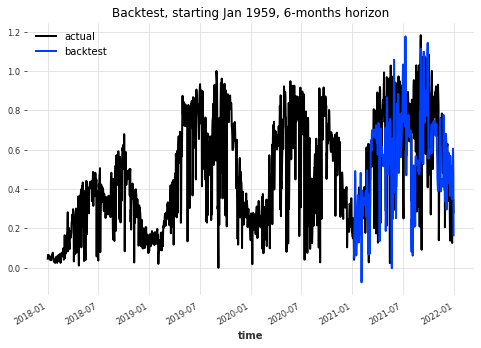

In [ ]:
plt.figure(figsize=(8, 5))
series_transformed.plot(label="actual")
backtest_series.plot(label="backtest")
plt.legend()
plt.title("Backtest, starting Jan 1959, 6-months horizon")
print(
    "MAPE: {:.2f}%".format(
        mape(
            transformer.inverse_transform(series_transformed),
            transformer.inverse_transform(backtest_series),
        )
    )
)

## Monthly sunspots
Let's now try a more challenging time series; that of the monthly number of sunspots since 1749. First, we build the time series from the data, and check its periodicity.

(True, 125)

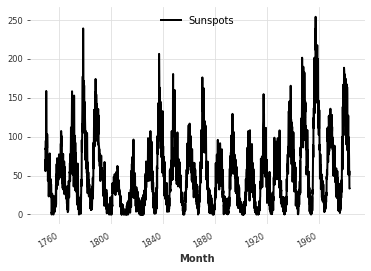

In [ ]:
series_sunspot = SunspotsDataset().load()

series_sunspot.plot()
check_seasonality(series_sunspot, max_lag=240)

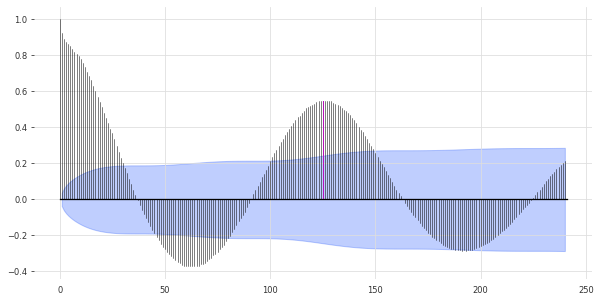

In [ ]:
# plot_acf(series_sunspot, 125, max_lag=240)  # ~11 years seasonality

In [ ]:
train_sp, val_sp = series_sunspot.split_after(pd.Timestamp("19401001"))

transformer_sunspot = Scaler()
train_sp_transformed = transformer_sunspot.fit_transform(train_sp)
val_sp_transformed = transformer_sunspot.transform(val_sp)
series_sp_transformed = transformer_sunspot.transform(series_sunspot)

In [ ]:
my_model_sun = BlockRNNModel(
    model="GRU",
    input_chunk_length=168,
    output_chunk_length=24,
    hidden_dim=10,
    n_rnn_layers=1,
    batch_size=32,
    n_epochs=300,
    dropout=0.1,
    model_name="sun_GRU",
    nr_epochs_val_period=1,
    optimizer_kwargs={"lr": 1e-3},
    log_tensorboard=True,
    random_state=42,
    force_reset=True,
    save_checkpoints=True
)

my_model_sun.fit(train_transformed, val_series=val_transformed, verbose=True)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
# my_model_sun = BlockRNNModel(
#     model="GRU",
#     input_chunk_length=125,
#     output_chunk_length=36,
#     hidden_dim=10,
#     n_rnn_layers=1,
#     batch_size=32,
#     n_epochs=100,
#     dropout=0.1,
#     model_name="sun_GRU",
#     nr_epochs_val_period=1,
#     optimizer_kwargs={"lr": 1e-3},
#     log_tensorboard=True,
#     random_state=42,
#     force_reset=True,
# )

# my_model_sun.fit(train_sp_transformed, val_series=val_sp_transformed, verbose=True)

  0%|          | 0/100 [00:00<?, ?it/s]

To evaluate our model, we will simulate historic forecasting with a forecasting horizon of 3 years across the validation set. To speed things up, we will only look at every 10th forecast. For the sake of comparison, let's also fit an exponential smoothing model.

Predicting: 68it [00:00, ?it/s]

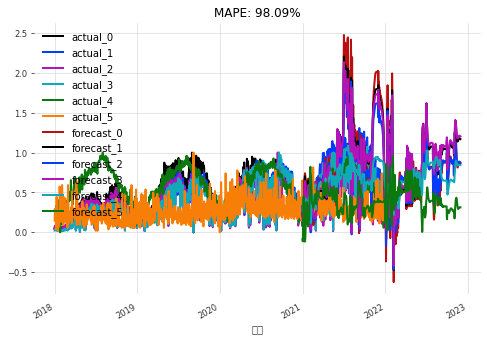

In [ ]:
def eval_model(model):
    pred_series = model.predict(n=699, future_covariates=covariates)
    plt.figure(figsize=(8, 5))
    series_transformed.plot(label="actual")
    pred_series.plot(label="forecast")
    plt.title("MAPE: {:.2f}%".format(mape(pred_series, val_transformed)))
    plt.legend()
    

eval_model(my_model)

In [ ]:
ff=my_model.predict(n=699, future_covariates=covariates)# predict
ff=transformer.inverse_transform(ff) #역 정규화
last_pred=ff[365:699]#2022년1월1일 2022년 11월30일
last_pred=last_pred.pd_dataframe() # 데이터프레임 변환
last_pred=last_pred.applymap(lambda x: 0 if x < 0 else x).reset_index() # -값 0으로 치환

Predicting: 68it [00:00, ?it/s]

In [ ]:
ff=my_model.predict(n=699, future_covariates=covariates)# predict

Predicting: 68it [00:00, ?it/s]

In [ ]:
best_model = BlockRNNModel.load_from_checkpoint(model_name="sun_GRU", best=True)
eval_model(best_model)

ValueError: ignored

In [ ]:
my_model_sun.historical_forecasts

<bound method ForecastingModel.historical_forecasts of <darts.models.forecasting.block_rnn_model.BlockRNNModel object at 0x7f7949b9f970>>

In [ ]:
# Compute the backtest predictions with the two models
pred_series = my_model_sun.historical_forecasts(
    series_transformed,
    start=pd.Timestamp("20210101"),
    forecast_horizon=300,
    stride=10,
    retrain=False,
    last_points_only=True,
    verbose=True,
)

# pred_series_ets = ExponentialSmoothing(seasonal_periods=120).historical_forecasts(
#     series_sp_transformed,
#     start=pd.Timestamp("19401001"),
#     forecast_horizon=36,
#     stride=10,
#     retrain=True,
#     last_points_only=True,
#     verbose=True,
# )


  0%|          | 0/7 [00:00<?, ?it/s]

Predicting: 29it [00:00, ?it/s]


 14%|█▍        | 1/7 [00:00<00:01,  4.30it/s]

Predicting: 29it [00:00, ?it/s]


 29%|██▊       | 2/7 [00:00<00:01,  4.71it/s]

Predicting: 29it [00:00, ?it/s]


 43%|████▎     | 3/7 [00:00<00:00,  4.85it/s]

Predicting: 29it [00:00, ?it/s]


 57%|█████▋    | 4/7 [00:00<00:00,  4.53it/s]

Predicting: 29it [00:00, ?it/s]


 71%|███████▏  | 5/7 [00:01<00:00,  4.72it/s]

Predicting: 29it [00:00, ?it/s]


 86%|████████▌ | 6/7 [00:01<00:00,  4.49it/s]

Predicting: 29it [00:00, ?it/s]


100%|██████████| 7/7 [00:01<00:00,  4.48it/s]


In [ ]:
pred_series

<TimeSeries (DataArray) (time: 7, component: 6, sample: 1)>
array([[[0.41158778],
        [0.34369184],
        [0.33121817],
        [0.31676417],
        [0.58495805],
        [0.25680704]],

       [[0.39328475],
        [0.32810495],
        [0.31469794],
        [0.29808963],
        [0.57778702],
        [0.25318962]],

       [[0.39961772],
        [0.32468201],
        [0.32618518],
        [0.29973222],
        [0.5719361 ],
        [0.25593213]],
...
       [[0.41864198],
        [0.33252485],
        [0.34691201],
        [0.3123579 ],
        [0.58218042],
        [0.25732612]],

       [[0.42672337],
        [0.34025767],
        [0.35355612],
        [0.32121559],
        [0.58656588],
        [0.25867543]],

       [[0.44153023],
        [0.35083199],
        [0.36716009],
        [0.33419884],
        [0.59668444],
        [0.25977834]]])
Coordinates:
  * time       (time) datetime64[ns] 2021-10-27 2021-11-06 ... 2021-12-26
  * component  (component) object '광진구' '동대문구' '성동구' '중랑구' '평균기온' '평균풍속'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

RNN MAPE: 77.55595281563177


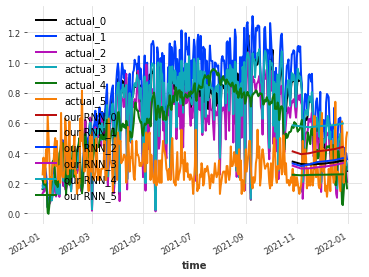

In [ ]:
val_transformed.plot(label="actual")
pred_series.plot(label="our RNN")
# pred_series_ets.plot(label="ETS")
plt.legend()
print("RNN MAPE:", mape(pred_series, val_transformed))
# print("ETS MAPE:", mape(pred_series_ets, val_sp_transformed))

In [ ]:
####nhits
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

from darts import TimeSeries

import tensorflow as tf
tf.compat.v1.enable_eager_execution()

from tensorflow.keras.layers import MaxPool1D

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


In [ ]:
import pandas as pd
train = pd.read_csv('/content/drive/MyDrive/따릉이/data/train_data/train.csv')
temp_df=pd.read_csv('/content/drive/MyDrive/따릉이/data/서울_온도_강수량_풍속.csv',encoding='cp949')
temp_df.drop(['지점','지점명'],axis=1,inplace=True)
temp_df['일시'] = temp_df.일시.apply(lambda x: datetime.strptime(str(x),'%Y-%m-%d'))
temp_df.fillna(0,inplace=True)
#train['일강수량']=temp_df['일강수량(mm)']
#train['평균풍속']=temp_df['평균 풍속(m/s)']
#train['눈']=temp_df['합계 3시간 신적설(cm)']
train['평균기온']=temp_df['평균기온(°C)']

In [ ]:
from darts import TimeSeries
from datetime import datetime

# Read a pandas DataFrame
df=train
df['일시'] = df.일시.apply(lambda x: datetime.strptime(str(x),'%Y%m%d'))
#df.set_index('일시',inplace=True)
# Create a TimeSeries, specifying the time and value columns
series = TimeSeries.from_dataframe(df, "일시", ["광진구","동대문구","성동구","중랑구","평균기온"])

# Set aside the last 36 months as a validation series
train, val = series[:1096], series[1096:]
## Read data:
#series = AirPassengersDataset().load()

## Create training and validation sets:
#train, val = series.split_after(pd.Timestamp("19590101"))

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

# create month and year covariate series
year_series = datetime_attribute_timeseries(
    pd.date_range(start=series.start_time(), freq=series.freq_str, periods=1795),
    attribute="year",
    one_hot=False,
)
year_series = Scaler().fit_transform(year_series)
month_series = datetime_attribute_timeseries(
    year_series, attribute="month", one_hot=True
)
covariates = year_series.stack(month_series)
cov_train, cov_val = covariates.split_after(pd.Timestamp("2020-12-31"))

In [ ]:
nn.L1Loss()

In [ ]:
from darts.models import NHiTSModel
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mae
train_scaler = Scaler()
scaled_train = train_scaler.fit_transform(train)

nhits = NHiTSModel(
    input_chunk_length=168, 
    output_chunk_length=24,
    random_state=42,loss_fn=nn.L1Loss())

nhits.fit(
    scaled_train,
    epochs=50)

scaled_pred_nhits = nhits.predict(n=699)
pred_nhits = train_scaler.inverse_transform(scaled_pred_nhits)

mae_nhits = mae(val, pred_nhits)

print(mae_nhits)

Training: 0it [00:00, ?it/s]

Predicting: 29it [00:00, ?it/s]

3.7311875661291354


In [ ]:
mae_nhits = mae(val, pred_nhits)

print(mae_nhits)

3.8364344403165545


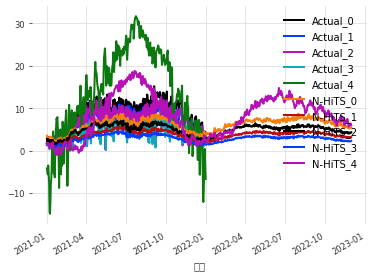

In [ ]:
val.plot(label='Actual')
pred_nhits.plot(label='N-HiTS')

In [ ]:
last_pred=pred_nhits[365:699]#2022년1월1일 2022년 11월30일
last_pred=last_pred.pd_dataframe() # 데이터프레임 변환
last_pred=last_pred.applymap(lambda x: 0 if x < 0 else x).reset_index() # -값 0으로 치환

In [ ]:
last_pred.max(),last_pred.min(),last_pred.mean()

(component
 일시      2022-11-30 00:00:00
 광진구                8.741172
 동대문구               4.711716
 성동구                6.453199
 중랑구                3.607572
 평균기온              14.775353
 dtype: object, component
 일시      2022-01-01 00:00:00
 광진구                 3.57452
 동대문구               1.933946
 성동구                2.456878
 중랑구                1.341838
 평균기온               1.717161
 dtype: object, component
 광진구     6.598024
 동대문구    3.781582
 성동구     5.070701
 중랑구     2.834817
 평균기온    8.717748
 dtype: float64)

In [ ]:
last_pred

component         일시       광진구      동대문구       성동구       중랑구
0         2022-01-01  3.064893  2.895319  1.701475  1.994603
1         2022-01-02  3.113596  2.504383  1.769407  1.780802
2         2022-01-03  2.187900  2.055113  1.124847  1.306757
3         2022-01-04  2.182153  1.795097  1.127230  1.290292
4         2022-01-05  2.989584  2.514264  1.813857  1.629763
..               ...       ...       ...       ...       ...
329       2022-11-26  3.492335  3.047825  2.121127  2.076201
330       2022-11-27  4.051405  3.032469  2.525021  2.005949
331       2022-11-28  3.153175  2.386030  1.914167  1.669926
332       2022-11-29  2.553934  2.227324  1.420457  1.606136
333       2022-11-30  2.635875  2.312176  1.931031  1.839076

[334 rows x 5 columns]

In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/따릉이/data/train_data/sample_submission.csv')
submit.head()
submit['광진구']=last_pred.광진구
submit['동대문구']=last_pred.동대문구
submit['성동구']=last_pred.성동구
submit['중랑구']=last_pred.중랑구
submit=submit.set_index('일시')
submit.to_csv('/content/drive/MyDrive/따릉이/data/submit/submit_nhits_온도.csv')